In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 0. Загрузка данных

In [140]:
df = pd.read_csv('../content/Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## 1. Первичный и визуальный анализ данных

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


В датасете 200 наблюдений, 5 признаков: 4 вещественных и 1 категориальный. Пропусков нет.

In [105]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


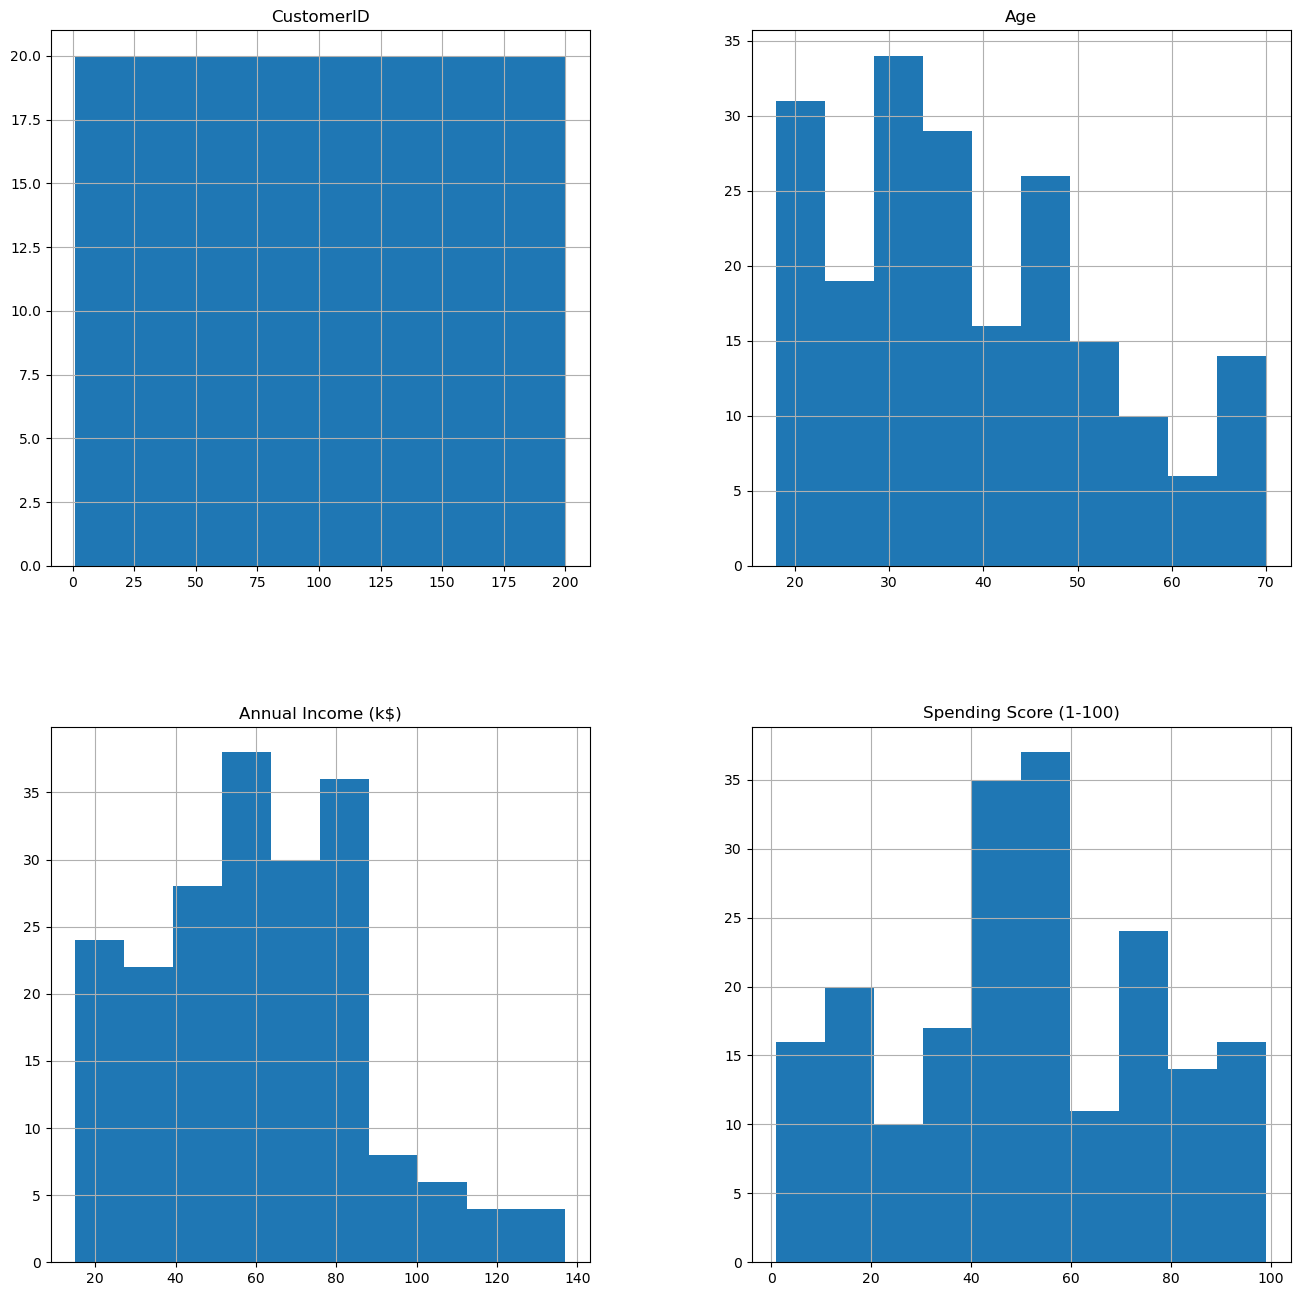

In [141]:
# отделение вещественных признаков
num_features = list(df.select_dtypes(['int64']).columns)

df.hist(num_features, figsize=(16, 16));

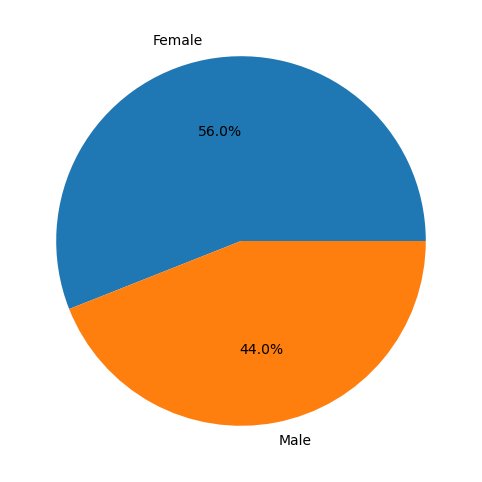

In [48]:
df_to_pie = df['Gender'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(df_to_pie.values, labels=df_to_pie.index, autopct='%.1f%%');

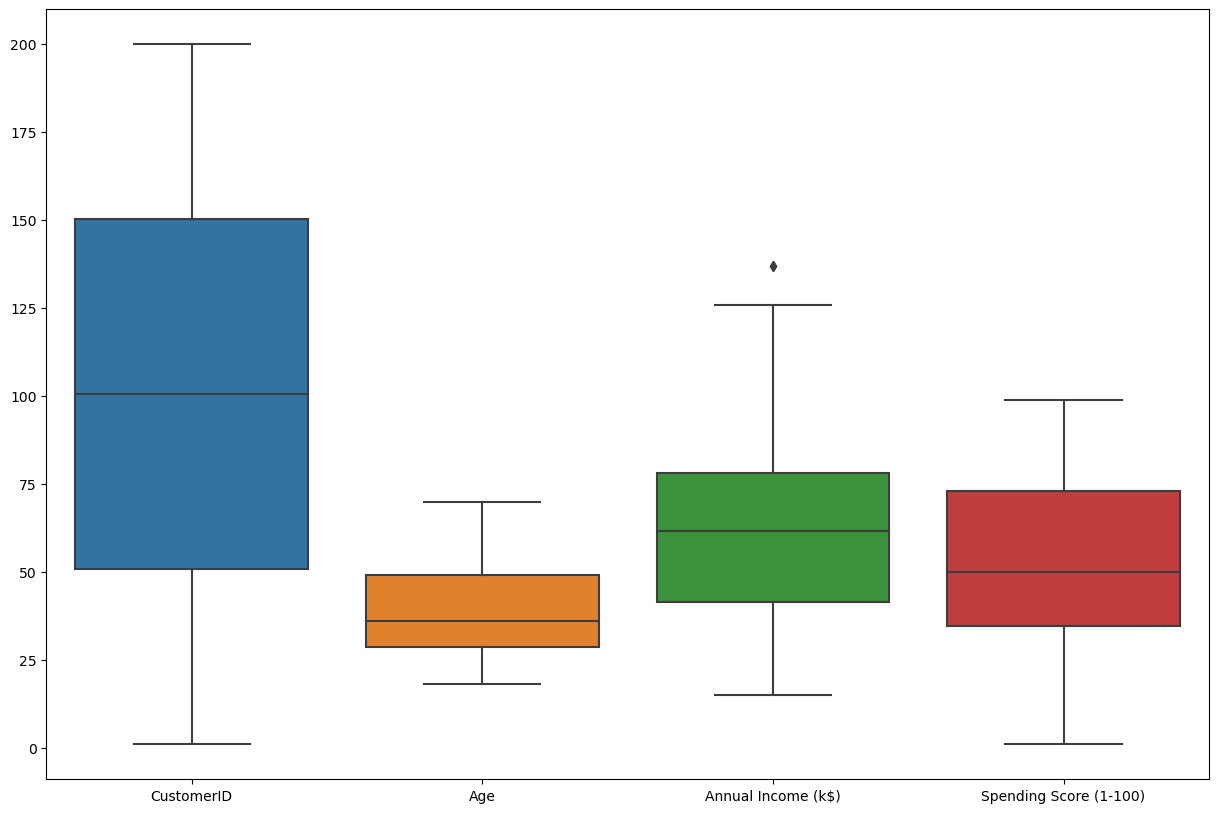

In [49]:
plt.figure(figsize=(15, 10))
sns.boxplot(df[num_features]);

Судя по диаграмме размаха, выбросы имеются только у признака `Annual Income`.

Посмотрим на плотность распределения вероятности признака `Spending Score (1-100)` - оценка расходов

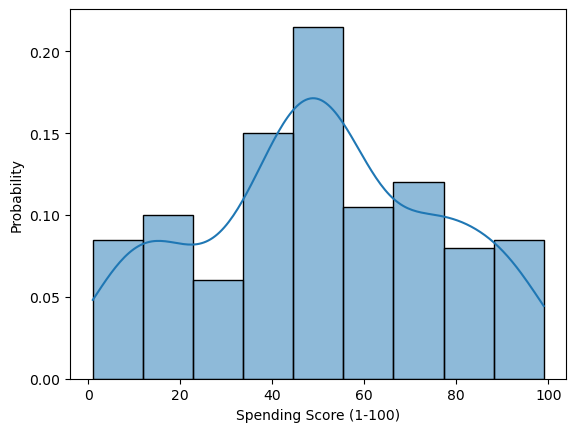

In [55]:
sns.histplot(df['Spending Score (1-100)'], kde=True, stat='probability');

## 2. Удаление бесполезных признаков

Признак `CustomerID` выступает в роли счетчика и не несёт смысловой нагрузки.

In [142]:
num_features.remove('CustomerID')

## 3. Предобработка данных

In [123]:
# cat_features = ['Gender']

In [150]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

num_pipe = make_pipeline(
    # MinMaxScaler()
    StandardScaler()
)

cat_pipe = make_pipeline(
    OneHotEncoder(handle_unknown="ignore")          # игнорирование неопознанных данных на тесте или в рабочих данных
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_features),
        ("cat", cat_pipe, ['Gender']),
    ]
)


In [151]:
df_transform = preprocessor.fit_transform(df)

In [152]:
# имена колонок
col_names = num_features.copy()
col_names.append('Gender_Female')
col_names.append('Gender_Male')

In [153]:
df_transform = pd.DataFrame(df_transform, columns=col_names)
df_transform

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
0,-1.424569,-1.738999,-0.434801,0.0,1.0
1,-1.281035,-1.738999,1.195704,0.0,1.0
2,-1.352802,-1.700830,-1.715913,1.0,0.0
3,-1.137502,-1.700830,1.040418,1.0,0.0
4,-0.563369,-1.662660,-0.395980,1.0,0.0
...,...,...,...,...,...
195,-0.276302,2.268791,1.118061,1.0,0.0
196,0.441365,2.497807,-0.861839,1.0,0.0
197,-0.491602,2.497807,0.923953,0.0,1.0
198,-0.491602,2.917671,-1.250054,0.0,1.0


## 4. Обучение модели понижения размерности для визуализации данных в 2D пространстве

## 5. Отбор признаков минимум с помощью трех подходов

### 5.0 Функции-конструкторы новых признаков

In [23]:
from sklearn.preprocessing import LabelEncoder
from category_encoders.count import CountEncoder


def get_one_hot(X, cols):
    for each in cols:
        dummies = pd.get_dummies(X[each], prefix=each)   # бинарное представление категории
        X = pd.concat([X, dummies], axis=1)             # соединияем с исходным дата-фреймом
    return X

def get_label(X, cols):
    X = X.copy()                                        # работаем с копией
    for each in cols:
        le = LabelEncoder()
        labels = le.fit_transform(X[each])               # получаем метки (0, 1, 2 и т.д.) через LabelEncoder
        X[each] = labels
    return X

def get_count(X, cols):
    X = X.copy()

    for col in cols:
        X[col] = X[col].astype('str')

    ce = CountEncoder(handle_unknown=-1)
    ce.fit(X[cols])
    X[cols] = ce.transform(X[cols])
    return X


In [24]:
cat_features

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [25]:
X = get_one_hot(X, cols=['workclass','marital-status', 'native-country'])
X = get_label(X, cols=['occupation', 'relationship', 'education'])
X = get_count(X, cols=['sex', 'race', 'relationship'])
X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,77516,13,2174,0,40,State-gov,9,Never-married,1,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,Self-emp-not-inc,9,Married-civ-spouse,4,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,Private,11,Divorced,6,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,Private,1,Married-civ-spouse,6,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,Private,9,Married-civ-spouse,10,...,0,0,0,0,0,0,0,0,0,0


In [26]:
X = X.drop(columns=cat_features)
X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 5.1 Одномерный отбор признаков

In [27]:
%%time
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

selector = SelectKBest(f_classif, k=40)
X_new = selector.fit_transform(X, y)
X_new.shape

CPU times: user 77.7 ms, sys: 49.6 ms, total: 127 ms
Wall time: 435 ms


(32561, 40)

Отчет о классификации для тренировочных данных:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     18539
           1       0.72      0.58      0.64      5881

    accuracy                           0.84     24420
   macro avg       0.80      0.75      0.77     24420
weighted avg       0.84      0.84      0.84     24420


Отчет о классификации для тестовых данных:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6181
           1       0.73      0.59      0.65      1960

    accuracy                           0.85      8141
   macro avg       0.80      0.76      0.78      8141
weighted avg       0.84      0.85      0.84      8141




<Figure size 1200x1000 with 0 Axes>

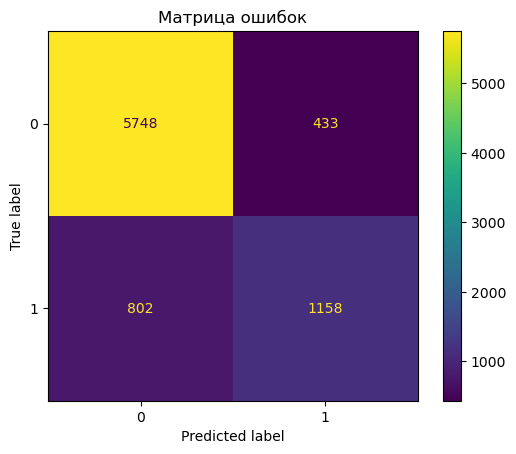

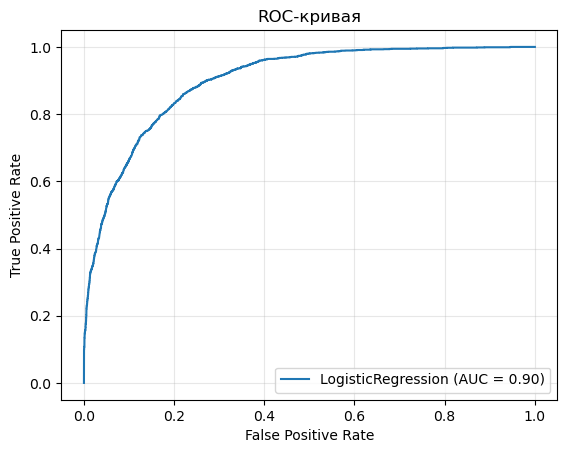

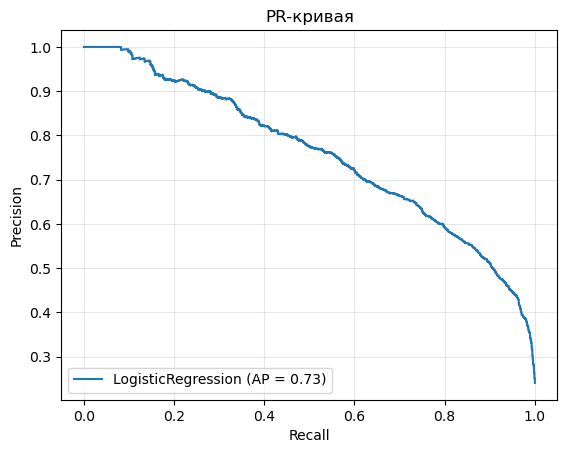

In [28]:
model = get_score(X_new, y, is_return=True)

### 5.2 Рекурсивный отбор признаков

In [29]:
from sklearn.feature_selection import RFE

selector = RFE(model, n_features_to_select=35, step=1)
selector = selector.fit(X_new, y)

In [30]:
X_new2 = selector.transform(X_new)
X_new2.shape

(32561, 35)

Отчет о классификации для тренировочных данных:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89     18539
           1       0.68      0.50      0.57      5881

    accuracy                           0.82     24420
   macro avg       0.77      0.71      0.73     24420
weighted avg       0.81      0.82      0.81     24420


Отчет о классификации для тестовых данных:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      6181
           1       0.69      0.50      0.58      1960

    accuracy                           0.83      8141
   macro avg       0.77      0.72      0.74      8141
weighted avg       0.82      0.83      0.82      8141




<Figure size 1200x1000 with 0 Axes>

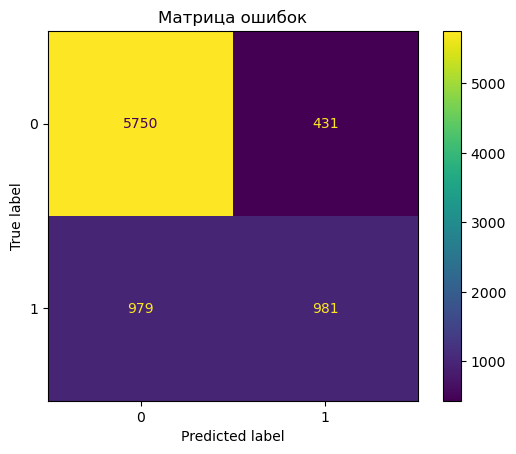

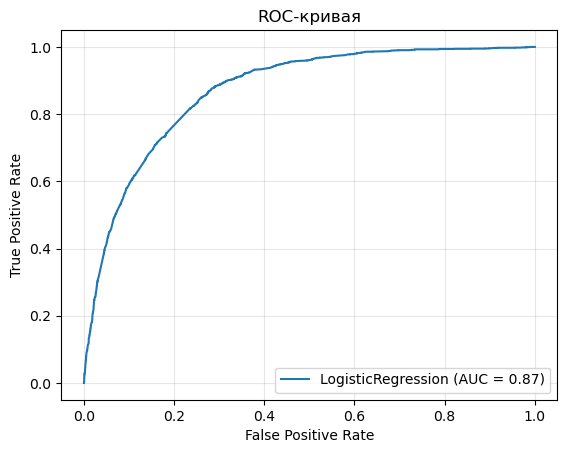

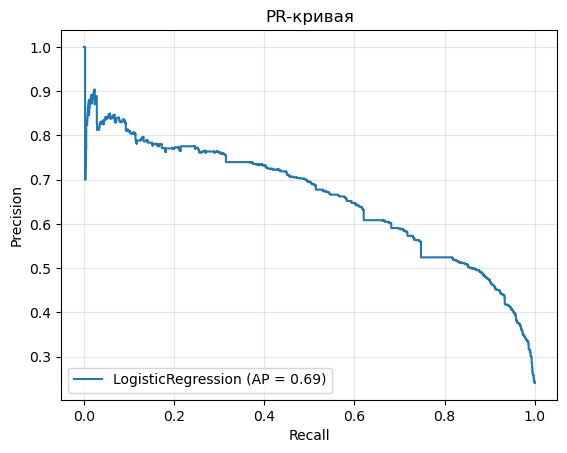

In [31]:
get_score(X_new2, y)

### 5.3 Переборный отбор признаков

In [32]:
%%time
from sklearn.feature_selection import SequentialFeatureSelector

sfs_forward = SequentialFeatureSelector(
    model, n_features_to_select='auto', direction="forward"
)
sfs_forward.fit(X_new2, y)

CPU times: user 8min 14s, sys: 18 s, total: 8min 32s
Wall time: 6min 28s


SequentialFeatureSelector(estimator=LogisticRegression(),
                          n_features_to_select='auto')

In [33]:
X_new3 = sfs_forward.transform(X_new2)
X_new3.shape

(32561, 17)

Отчет о классификации для тренировочных данных:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89     18539
           1       0.69      0.48      0.56      5881

    accuracy                           0.82     24420
   macro avg       0.77      0.70      0.73     24420
weighted avg       0.81      0.82      0.81     24420


Отчет о классификации для тестовых данных:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      6181
           1       0.70      0.48      0.57      1960

    accuracy                           0.83      8141
   macro avg       0.77      0.71      0.73      8141
weighted avg       0.81      0.83      0.81      8141




<Figure size 1200x1000 with 0 Axes>

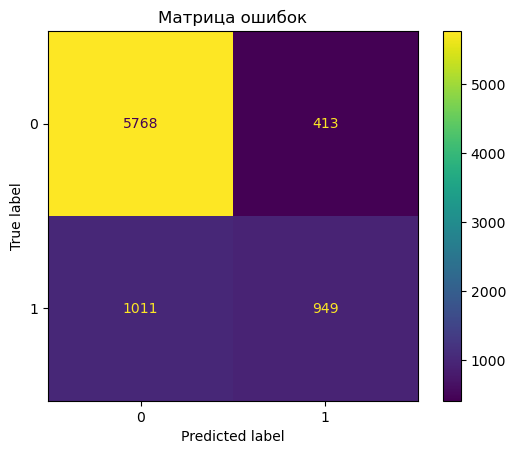

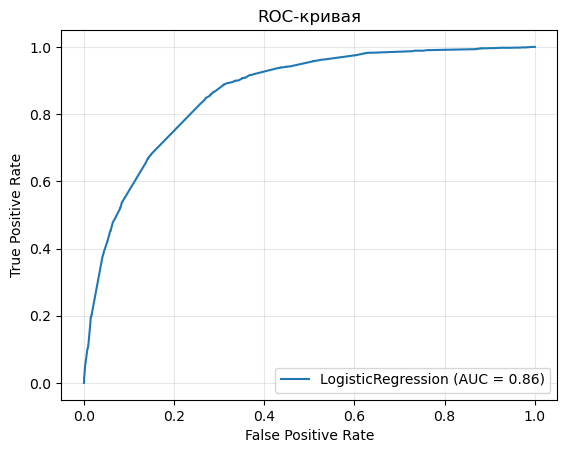

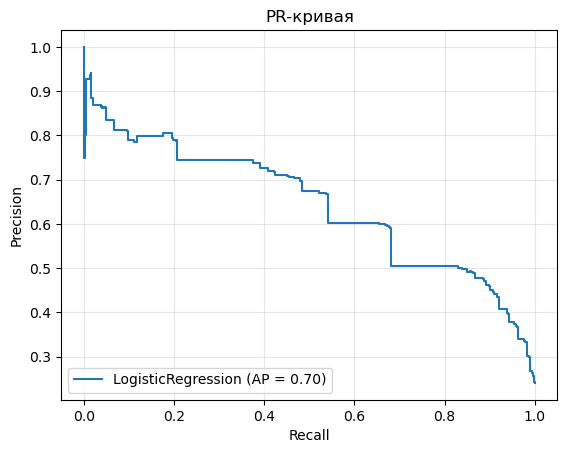

In [34]:
get_score(X_new3, y)

## 6. Выводы о проделанной работе

**Базовое решение:**

F1-score (для теста, макроусреднённая) - **0.70**. Площадь под ROC-кривой - **0.83**. Средняя точность - **0.70**.

**Решение с предобработкой данных:**

F1-score (для теста, макроусреднённая) равна **0.79**. Площадь под ROC-кривой - **0.91**. Средняя точность - **0.74**.

**Решение с отбором признаков:**

1. Одномерный отбор признаков:

    F1-score (для теста, макроусреднённая) равна **0.78**. Площадь под ROC-кривой - **0.90**. Средняя точность - **0.73**.

2. Рекурсивный отбор признаков:

    F1-score (для теста, макроусреднённая) равна **0.74**. Площадь под ROC-кривой - **0.87**. Средняя точность - **0.69**.

3. Переборный отбор признаков (количество признаков для отбора выбиралось селектором автоматически):

    F1-score (для теста, макроусреднённая) равна **0.73**. Площадь под ROC-кривой - **0.86**. Средняя точность - **0.70**.


Базовое решение хуже всех по показателям. Предобработка данных дала лучшие результаты. Одномерный отбор признаков по качеству практически такое же, как с предобработкой данных. Переборный отбор на 15 признаках дает практически такой же результат, как рекурсивный на 35.